# NLP with Disaster Tweets

In [172]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import spacy

nlp = spacy.load('en_core_web_sm')

## Loading the data and getting basic idea

In [173]:
drive_data_root = '/content/drive/MyDrive/Kaggle/NLP-with-Disaster-Tweets/Data/Raw'

# Load data from Google Drive.
train_df = pd.read_csv(f'{drive_data_root}/train.csv')
test_df = pd.read_csv(f'{drive_data_root}/test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Exploratory Data Analysis (EDA)
In this step we explore and investigations the following some of the aspects of our datasets. Namely we examine the following ideas:

- Check the usefulness of 'id' column regarding 'target'.
- Preprocessing steps required for the text.
- Possible Feature Extractions of the text.
- Explore 'location' and 'keyword' columns, find their distributions and relations with the 'target'.

### Location
After careful investigation of the 'location' column, the followings where noted:
- Some countries have different naming convensions (eg. USA, United states)
- There are some spelling errors (eg. T E X A S)
- Fill or remove NULL entries for this column (33%)

- There are 2533 missing entries on "location" column (33.27%)
- Number of unique locations: 3342 (43.9%)


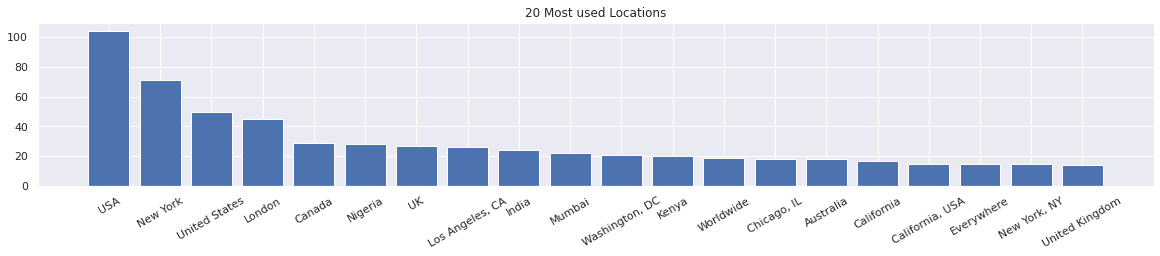

In [182]:
# NULL entries
null_entries = train_df.loc[train_df['location'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "location" column ({round(null_entries_count / train_df.shape[0] * 100, 2)}%)')

# Uniqueness
unique_locations = train_df['location'].unique()
unique_locations_count = len(unique_locations)
print(f'- Number of unique locations: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

# 20 Top Frequencies
location_freq = train_df['location'].value_counts()
top_20_locs = location_freq[:20]

fig = plt.figure(figsize = (20, 3))
plt.title('20 Most used Locations')
plt.bar(top_20_locs.index, top_20_locs.values)
plt.xticks(rotation = 30)
plt.show()

### Keyword
Some notes to keep in mind for later fix:
- Most keywords contain space with is represented by '%20'
- Most keywords indicate distaster signs according to our graph!
- 

- There are 61 missing entries on "keyword" column (0.8%)
Number of unique keyword: 222 (2.92%)


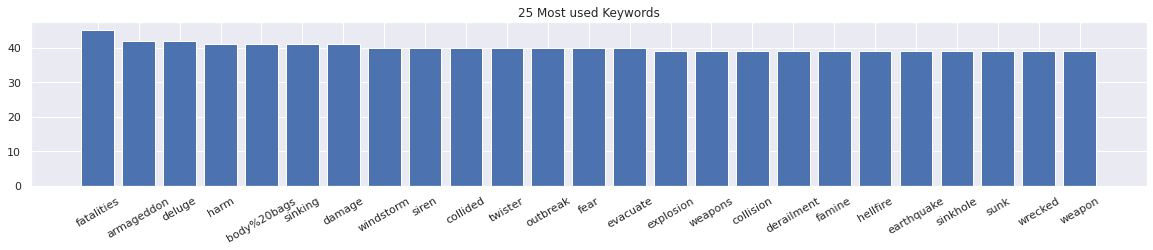

In [184]:
# NULL entries
null_entries = train_df.loc[train_df['keyword'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "keyword" column ({round(null_entries_count / train_df.shape[0] * 100, 2)}%)')

# Uniqueness
unique_locations = train_df['keyword'].unique()
unique_locations_count = len(unique_locations)
print(f'Number of unique keyword: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

# 2t Top Frequencies
keyword_freq = train_df['keyword'].value_counts()
keys_25_locs = keyword_freq[:25]

fig = plt.figure(figsize = (20, 3))
plt.title('25 Most used Keywords')
plt.bar(keys_25_locs.index, keys_25_locs.values)
plt.xticks(rotation = 30)
plt.show()

### Text
Things to keep in mind:
- There exist hashtags that can be useful and extracted as features.
- Links exist in some texts that must be removed or used.
- Mentions can be seen across comments.
- None-ASCII characters must be removed.
- Lot's of misleading punctuations exist.
- Numbers must be dealt with.
- Some comments are all in capital form.
- Repeated comments with only link to differ (See text[110:120])

#### Frequency

In [124]:
for text in train_df['text'].iloc[100:110]:
  print('-', text)

- .@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad
- I still have not heard Church Leaders of Kenya coming forward to comment on the accident issue and disciplinary measures#ArrestPastorNganga
- @afterShock_DeLo scuf ps live and the game... cya
- 'The man who can drive himself further once the effort gets painful is the man who will win.' 
Roger Bannister
- 320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yNXnvVKCDA | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/weQPesENku
- 'There is no victory at bargain basement prices.' Dwight David Eisenhower
- 320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vAM5POdGyw | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/zEVakJaPcz
- 'Nobody remembers who came in second.' Charles Schulz
- @afterShock_DeLo im speaking from someone that is using a scuf on xb1 most of them people will end up getting on for ps also.
- 'The harder the confli

### Target

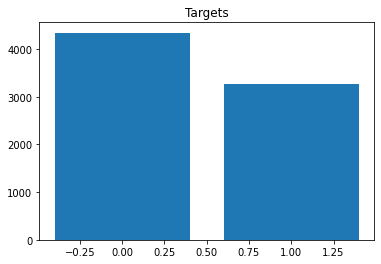

In [132]:
target_counts = train_df.groupby(by = 'target', as_index = False).count()['id']

plt.title('Targets')
plt.bar(target_counts.index, target_counts.values)
plt.show()

## Data Preprocessing

In [166]:
def clean_text(text):
  pass

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
